# Quantum kernel vs machine learning classic

## DLP amb ML classic 
Comencem veien com ml classic fa amb el problema del logaritme discret

In [43]:
# Reexecutem després del reset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

# ----------------------
# FUNCIONS AUXILIARS
# ----------------------
def generate_dataset(p, g):
    X = np.arange(1, p)
    log_table = {pow(g, i, p): i for i in range(1, p)}
    X_log = np.array([log_table[x] for x in X])

    s = np.random.randint(0, p - 2)
    r = (p - 3) // 2
    label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

    def assign_label(log_val):
        if label_range[0] < label_range[1]:
            return 1 if label_range[0] <= log_val <= label_range[1] else -1
        else:
            return 1 if log_val >= label_range[0] or log_val <= label_range[1] else -1

    y = np.array([assign_label(val) for val in X_log])
    X_reshaped = X.reshape(-1, 1) / p
    return X_reshaped, y

# ----------------------
# BUCLE D'ITERACIONS
# ----------------------
p = 599
g = 7
n_iter = 20

best_acc_lr = 0
best_acc_svm = 0

for _ in range(n_iter):
    X, y = generate_dataset(p, g)
    perm = np.random.permutation(len(X))
    X_scrambled = X[perm]
    y_scrambled = y[perm]
    X_train, X_test, y_train, y_test = train_test_split(X_scrambled, y_scrambled, test_size=0.3, random_state=42)

    clf_lr = LogisticRegression().fit(X_train, y_train)
    acc_lr = accuracy_score(y_test, clf_lr.predict(X_test))
    best_acc_lr = max(best_acc_lr, acc_lr)

    clf_svm = SVC(kernel='rbf').fit(X_train, y_train)
    acc_svm = accuracy_score(y_test, clf_svm.predict(X_test))
    best_acc_svm = max(best_acc_svm, acc_svm)

# ----------------------
# RESULTATS FINALS
# ----------------------
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM (RBF kernel)'],
    'Best Accuracy': [best_acc_lr, best_acc_svm]
})

print(results_df)

                 Model  Best Accuracy
0  Logistic Regression       0.550000
1     SVM (RBF kernel)       0.566667


In [72]:
from sympy import isprime, primerange, is_primitive_root
import matplotlib.pyplot as plt
# Paràmetres i configuració
prime_range = list(primerange(100, 1000))
n_iter_per_p = 30
results_best = []

for p in prime_range:
    g = next((g for g in range(2, p) if is_primitive_root(g, p)), None)
    if g is None:
        continue

    best_acc_lr = 0
    best_acc_svm = 0

    for _ in range(n_iter_per_p):
        X, y = generate_dataset(p, g)
        if X is None:
            break
        perm = np.random.permutation(len(X))
        X_scrambled = X[perm]
        y_scrambled = y[perm]
        X_train, X_test, y_train, y_test = train_test_split(X_scrambled, y_scrambled, test_size=0.3, random_state=42)

        clf_lr = LogisticRegression().fit(X_train, y_train)
        acc_lr = accuracy_score(y_test, clf_lr.predict(X_test))
        best_acc_lr = max(best_acc_lr, acc_lr)

        clf_svm = SVC(kernel='rbf').fit(X_train, y_train)
        acc_svm = accuracy_score(y_test, clf_svm.predict(X_test))
        best_acc_svm = max(best_acc_svm, acc_svm)

    results_best.append((p, best_acc_lr, best_acc_svm))

# Convertim a DataFrame i mostrem
results_df_best = pd.DataFrame(results_best, columns=['Prime p', 'Best LR Accuracy', 'Best SVM Accuracy'])



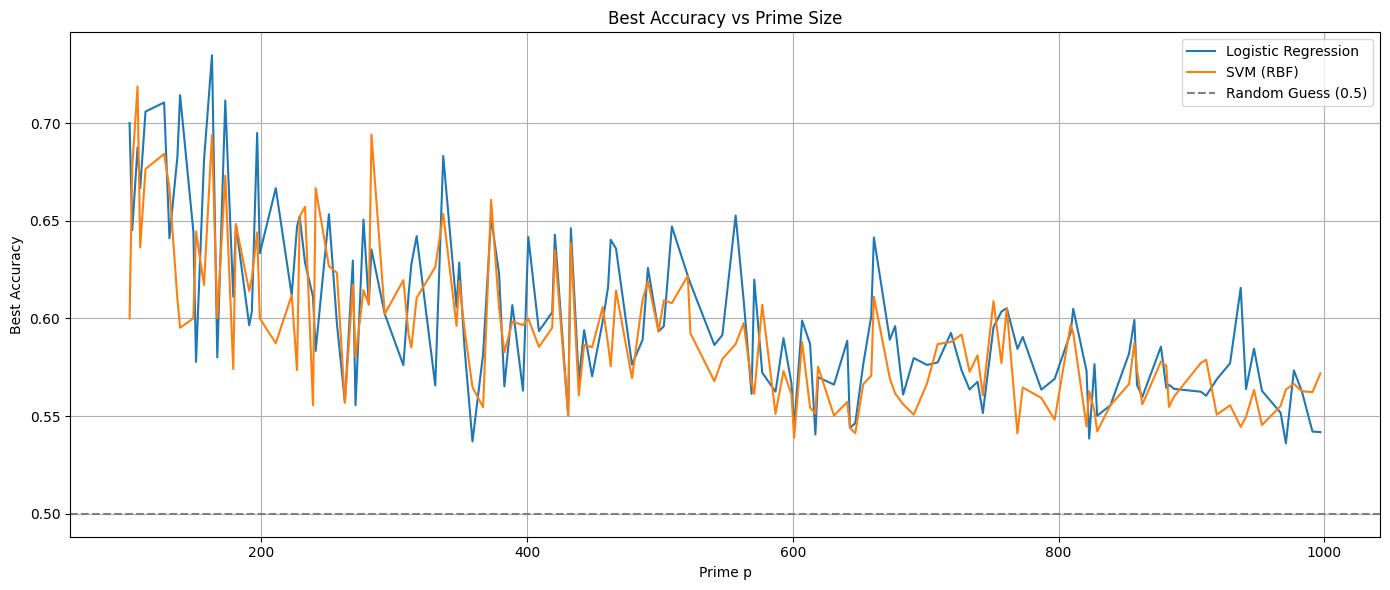

In [73]:
# Gràfic millor format amb línia de referència a y = 0.5 i eix X més allargat
plt.figure(figsize=(14, 6))
plt.plot(results_df_best['Prime p'], results_df_best['Best LR Accuracy'], label='Logistic Regression')
plt.plot(results_df_best['Prime p'], results_df_best['Best SVM Accuracy'], label='SVM (RBF)')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Guess (0.5)')
plt.xlabel('Prime p')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy vs Prime Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## DPL amb QML quantum kernel

In [74]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Dataset i configuració
p = 199
g = 3

def custom_feature_map_3qubits(x, theta=np.pi/2):
    qc = QuantumCircuit(3)
    for i in range(3):
        qc.ry(theta, i)
        qc.rz(-2 * x[i], i)
        qc.rx(-2 * x[i], i)
    qc.cz(0, 1)
    qc.cz(1, 2)
    qc.cz(0, 2)
    return Statevector.from_instruction(qc)

def quantum_kernel_matrix(X1, X2, theta=np.pi/2):
    kernel = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        sv1 = custom_feature_map_3qubits(X1[i], theta)
        for j in range(len(X2)):
            sv2 = custom_feature_map_3qubits(X2[j], theta)
            kernel[i, j] = np.abs(sv1.data.conj().T @ sv2.data) ** 2
    return kernel
    
# Genera dataset
X = np.arange(1, p).reshape(-1, 1)
log_table = {pow(g, i, p): i for i in range(1, p)}
X_log = np.array([log_table[x[0]] for x in X])

s = np.random.randint(0, p - 2)
r = (p - 3) // 2
label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

def assign_label(v):
    if label_range[0] < label_range[1]:
        return 1 if label_range[0] <= v <= label_range[1] else -1
    else:
        return 1 if v >= label_range[0] or v <= label_range[1] else -1

y = np.array([assign_label(val) for val in X_log])

# Escalat i duplicació
X_scaled = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)
X_dup = np.hstack([X_scaled]*3)

# Train/test
X_train, X_test, y_train, y_test = train_test_split(X_dup, y, test_size=0.3, random_state=42)

# Kernel + SVM
K_train = quantum_kernel_matrix(X_train, X_train)
K_test = quantum_kernel_matrix(X_test, X_train)
svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train)
acc = accuracy_score(y_test, svm.predict(K_test))

print(f"Millor accuracy amb Quantum Kernel personalitzat (3 qubits): {acc:.4f}")

Millor accuracy amb Quantum Kernel personalitzat (3 qubits): 0.5167


In [39]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Dataset i configuració
p = 199
g = 3
n_iter = 20
best_acc = 0

def custom_feature_map_3qubits(x, theta=np.pi/2):
    qc = QuantumCircuit(3)
    for i in range(3):
        qc.ry(theta, i)
        qc.rz(-2 * x[i], i)
        qc.rx(-2 * x[i], i)
    qc.cz(0, 1)
    qc.cz(1, 2)
    qc.cz(0, 2)
    return Statevector.from_instruction(qc)

def quantum_kernel_matrix(X1, X2, theta=np.pi/2):
    kernel = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        sv1 = custom_feature_map_3qubits(X1[i], theta)
        for j in range(len(X2)):
            sv2 = custom_feature_map_3qubits(X2[j], theta)
            kernel[i, j] = np.abs(sv1.data.conj().T @ sv2.data) ** 2
    return kernel

for _ in range(n_iter):
    # Genera dataset
    X = np.arange(1, p).reshape(-1, 1)
    log_table = {pow(g, i, p): i for i in range(1, p)}
    X_log = np.array([log_table[x[0]] for x in X])

    s = np.random.randint(0, p - 2)
    r = (p - 3) // 2
    label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

    def assign_label(v):
        if label_range[0] < label_range[1]:
            return 1 if label_range[0] <= v <= label_range[1] else -1
        else:
            return 1 if v >= label_range[0] or v <= label_range[1] else -1

    y = np.array([assign_label(val) for val in X_log])

    # Escalat i duplicació
    X_scaled = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)
    X_dup = np.hstack([X_scaled]*3)

    # Train/test
    X_train, X_test, y_train, y_test = train_test_split(X_dup, y, test_size=0.3, random_state=42)

    # Kernel + SVM
    K_train = quantum_kernel_matrix(X_train, X_train)
    K_test = quantum_kernel_matrix(X_test, X_train)
    svm = SVC(kernel='precomputed')
    svm.fit(K_train, y_train)
    acc = accuracy_score(y_test, svm.predict(K_test))
    best_acc = max(best_acc, acc)

print(f"Millor accuracy amb Quantum Kernel personalitzat (3 qubits): {best_acc:.4f}")


Millor accuracy amb Quantum Kernel personalitzat (3 qubits): 0.6000


## 1 qubit amb simulador statevector

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Dataset i configuració
p = 199
g = 3
n_iter = 20
best_acc = 0

# 👉 Feature map amb només 1 qubit
def custom_feature_map_1qubit(x, theta=np.pi/2):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(-2 * x[0], 0)
    qc.rx(-2 * x[0], 0)
    return Statevector.from_instruction(qc)

# 👉 Kernel quàntic amb 1 qubit
def quantum_kernel_matrix(X1, X2, theta=np.pi/2):
    kernel = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        sv1 = custom_feature_map_1qubit(X1[i], theta)
        for j in range(len(X2)):
            sv2 = custom_feature_map_1qubit(X2[j], theta)
            kernel[i, j] = np.abs(sv1.data.conj().T @ sv2.data) ** 2
    return kernel

for _ in range(n_iter):
    # Genera dataset
    X = np.arange(1, p).reshape(-1, 1)
    log_table = {pow(g, i, p): i for i in range(1, p)}
    X_log = np.array([log_table[x[0]] for x in X])

    s = np.random.randint(0, p - 2)
    r = (p - 3) // 2
    label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

    def assign_label(v):
        if label_range[0] < label_range[1]:
            return 1 if label_range[0] <= v <= label_range[1] else -1
        else:
            return 1 if v >= label_range[0] or v <= label_range[1] else -1

    y = np.array([assign_label(val) for val in X_log])

    # Escalat
    X_scaled = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)

    # 1 qubit → només 1 feature
    X_single = X_scaled  # ja és shape (n, 1)

    # Train/test
    X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.3, random_state=42)

    # Kernel + SVM
    K_train = quantum_kernel_matrix(X_train, X_train)
    K_test = quantum_kernel_matrix(X_test, X_train)
    svm = SVC(kernel='precomputed')
    svm.fit(K_train, y_train)
    acc = accuracy_score(y_test, svm.predict(K_test))
    best_acc = max(best_acc, acc)

print(f"Millor accuracy amb Quantum Kernel personalitzat (1 qubit): {best_acc:.4f}")


## 1 qubits Fake backend

In [79]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler, Session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
 
backend = FakeAlmadenV2()
sampler = Sampler(mode=backend, options={"default_shots": 10})
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

# Feature map amb 1 qubit
def custom_feature_map_1qubit(x, theta=np.pi/2):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(-2 * x[0], 0)
    qc.rx(-2 * x[0], 0)
    return qc

# Calcula kernel usant fidelitat entre estats (via circuits conjunts)
def quantum_kernel_matrix(X1, X2, theta=np.pi/2):
    kernel = np.zeros((len(X1), len(X2)))
    circuits = []
    pairs = []

    for i in range(len(X1)):
        for j in range(len(X2)):
            qc = QuantumCircuit(1)
            fm1 = custom_feature_map_1qubit(X1[i], theta)
            fm2 = custom_feature_map_1qubit(X2[j], theta).inverse()
            qc.compose(fm1, inplace=True)
            qc.compose(fm2, inplace=True)
            qc.measure_all()
            transpiled_qc = pass_manager.run(qc)
            circuits.append(transpiled_qc)
            pairs.append((i, j))

    results = sampler.run(circuits).result()
    meas = results[0].data.meas  # 👈 nou accés a les mesures
    print(meas)
    for idx, prob in enumerate(meas.get_counts):
        fid = prob.get(0, 0)  # fidelitat amb |0⟩
        i, j = pairs[idx]
        kernel[i, j] = fid

    return kernel

In [80]:
# Dataset i configuració
p = 199
g = 3
# Dataset
X = np.arange(1, p).reshape(-1, 1)
log_table = {pow(g, i, p): i for i in range(1, p)}
X_log = np.array([log_table[x[0]] for x in X])

s = np.random.randint(0, p - 2)
r = (p - 3) // 2
label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

def assign_label(v):
    if label_range[0] < label_range[1]:
        return 1 if label_range[0] <= v <= label_range[1] else -1
    else:
        return 1 if v >= label_range[0] or v <= label_range[1] else -1

y = np.array([assign_label(val) for val in X_log])

# Escalat
X_scaled = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)

# 1 qubit
X_single = X_scaled

# Split
X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.3, random_state=42)




In [81]:
# Kernel + SVM
K_train = quantum_kernel_matrix(X_train, X_train)
K_test = quantum_kernel_matrix(X_test, X_train)
svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train)
acc = accuracy_score(y_test, svm.predict(K_test))

print(f"Millor accuracy amb Quantum Kernel personalitzat (1 qubit, IBM Cloud): {acc:.4f}")

BitArray(<shape=(), num_shots=10, num_bits=1>)


TypeError: 'method' object is not iterable

## Ara fer amb 1qubits amb backend real

In [ ]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler, Session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(mode=backend, options={"default_shots": 10})
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

# Feature map amb 1 qubit
def custom_feature_map_1qubit(x, theta=np.pi/2):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(-2 * x[0], 0)
    qc.rx(-2 * x[0], 0)
    return qc

# Calcula kernel usant fidelitat entre estats (via circuits conjunts)
def quantum_kernel_matrix(X1, X2, theta=np.pi/2):
    kernel = np.zeros((len(X1), len(X2)))
    circuits = []
    pairs = []

    for i in range(len(X1)):
        for j in range(len(X2)):
            qc = QuantumCircuit(1)
            fm1 = custom_feature_map_1qubit(X1[i], theta)
            fm2 = custom_feature_map_1qubit(X2[j], theta).inverse()
            qc.compose(fm1, inplace=True)
            qc.compose(fm2, inplace=True)
            qc.measure_all()
            transpiled_qc = pass_manager.run(qc)
            circuits.append(transpiled_qc)
            pairs.append((i, j))

    results = sampler.run(circuits).result()
    meas = results[0].data.meas  # 👈 nou accés a les mesures
    
    for idx, prob in enumerate(meas):
        fid = prob.get(0, 0)  # fidelitat amb |0⟩
        i, j = pairs[idx]
        kernel[i, j] = fid

    return kernel
    
# Dataset i configuració
p = 199
g = 3
n_iter = 1
best_acc = 0

for _ in range(n_iter):
    # Dataset
    X = np.arange(1, p).reshape(-1, 1)
    log_table = {pow(g, i, p): i for i in range(1, p)}
    X_log = np.array([log_table[x[0]] for x in X])

    s = np.random.randint(0, p - 2)
    r = (p - 3) // 2
    label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

    def assign_label(v):
        if label_range[0] < label_range[1]:
            return 1 if label_range[0] <= v <= label_range[1] else -1
        else:
            return 1 if v >= label_range[0] or v <= label_range[1] else -1

    y = np.array([assign_label(val) for val in X_log])

    # Escalat
    X_scaled = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)

    # 1 qubit
    X_single = X_scaled

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.3, random_state=42)

    # Kernel + SVM
    K_train = quantum_kernel_matrix(X_train, X_train)
    K_test = quantum_kernel_matrix(X_test, X_train)
    svm = SVC(kernel='precomputed')
    svm.fit(K_train, y_train)
    acc = accuracy_score(y_test, svm.predict(K_test))
    best_acc = max(best_acc, acc)

print(f"Millor accuracy amb Quantum Kernel personalitzat (1 qubit, IBM Cloud): {best_acc:.4f}")


In [18]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler, Session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(mode=backend, options={"default_shots": 10})
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

# Feature map amb 1 qubit
def custom_feature_map_1qubit(x, theta=np.pi/2):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(-2 * x[0], 0)
    qc.rx(-2 * x[0], 0)
    return qc

# Calcula kernel usant fidelitat entre estats (via circuits conjunts)
def quantum_kernel_matrix(X1, X2, theta=np.pi/2):
    kernel = np.zeros((len(X1), len(X2)))
    circuits = []
    pairs = []

    for i in range(len(X1)):
        for j in range(len(X2)):
            qc = QuantumCircuit(1)
            fm1 = custom_feature_map_1qubit(X1[i], theta)
            fm2 = custom_feature_map_1qubit(X2[j], theta).inverse()
            qc.compose(fm1, inplace=True)
            qc.compose(fm2, inplace=True)
            qc.measure_all()
            transpiled_qc = pass_manager.run(qc)
            circuits.append(transpiled_qc)
            pairs.append((i, j))

    results = sampler.run(circuits).result()
    meas = results[0].data.meas  # 👈 nou accés a les mesures
    
    for idx, prob in enumerate(meas):
        fid = prob.get(0, 0)  # fidelitat amb |0⟩
        i, j = pairs[idx]
        kernel[i, j] = fid

    return kernel
    
# Dataset i configuració
p = 199
g = 3
n_iter = 1
best_acc = 0

for _ in range(n_iter):
    # Dataset
    X = np.arange(1, p).reshape(-1, 1)
    log_table = {pow(g, i, p): i for i in range(1, p)}
    X_log = np.array([log_table[x[0]] for x in X])

    s = np.random.randint(0, p - 2)
    r = (p - 3) // 2
    label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

    def assign_label(v):
        if label_range[0] < label_range[1]:
            return 1 if label_range[0] <= v <= label_range[1] else -1
        else:
            return 1 if v >= label_range[0] or v <= label_range[1] else -1

    y = np.array([assign_label(val) for val in X_log])

    # Escalat
    X_scaled = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)

    # 1 qubit
    X_single = X_scaled

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.3, random_state=42)

    # Kernel + SVM
    K_train = quantum_kernel_matrix(X_train, X_train)
    K_test = quantum_kernel_matrix(X_test, X_train)
    svm = SVC(kernel='precomputed')
    svm.fit(K_train, y_train)
    acc = accuracy_score(y_test, svm.predict(K_test))
    best_acc = max(best_acc, acc)

print(f"Millor accuracy amb Quantum Kernel personalitzat (1 qubit, IBM Cloud): {best_acc:.4f}")


KeyboardInterrupt: 

In [24]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_cloud',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/8cece2f5b77849faae3733c972693084:d12a9c47-0ec5-442d-a695-cbdaf07d3cb9::'
)
job = service.job('d0vcbfg7m9ds739j394g')
job_result[0].data.meas

KeyboardInterrupt: 

In [26]:
dir(job_result[0].data.meas)

['__abstractmethods__',
 '__and__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__non_callable_proto_members__',
 '__or__',
 '__parameters__',
 '__protocol_attrs__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_abc_impl',
 '_array',
 '_bytes_to_bitstring',
 '_bytes_to_int',
 '_get_counts',
 '_is_protocol',
 '_is_runtime_protocol',
 '_num_bits',
 '_prepare_broadcastable',
 '_shape',
 'array',
 'bitcount',
 'concatenate',
 'concatenate_bits',
 'concatenate_shots',
 'expectation_values',
 'from_bool_array',
 'from_counts',
 'from_samples',
 'get_bitstrings',
 'get_counts',
 'get_int_counts',
 '

In [1]:
X1 = X_train 
X2 = X_train
kernel = np.zeros((len(X1), len(X2)))
counts_list = job_result[0].data.meas.get_counts()  # 👈 nou accés a les mesures
print(counts_list)
pairs = []

for i in range(len(X1)):
    for j in range(len(X2)):
        pairs.append((i, j))

for idx, counts in enumerate(counts_list):
    total = sum(counts.values())
    fid = counts.get("0", 0) / total if total else 0
    i, j = pairs[idx]
    kernel[i, j] = fid

NameError: name 'X_train' is not defined